HPA_KF
POTデータの範囲 15.12 ~ 35.22 POTデータ数: 161
最大尤度: 9.630662626828168e-32
最尤推定 ξ: -0.38190954773869346 σ: 8.2191181519979 RV: 34.82043610480725
HFA_KF_c0
POTデータの範囲 15.03 ~ 35.11 POTデータ数: 131
最大尤度: 1.2785338519179753e-35
最尤推定 ξ: -0.5477386934673367 σ: 11.511732463577745 RV: 35.36568765594005
HPA_YS
POTデータの範囲 15.15 ~ 29.44 POTデータ数: 99
最大尤度: 2.0488069942214115e-10
最尤推定 ξ: -0.46733668341708545 σ: 7.236550361033318 RV: 29.68834603689082
HFA_YS_c0
POTデータの範囲 15.01 ~ 31.85 POTデータ数: 84
最大尤度: 2.0227585569561614e-11
最尤推定 ξ: -0.36180904522613067 σ: 6.992699104950136 RV: 31.980824718311922


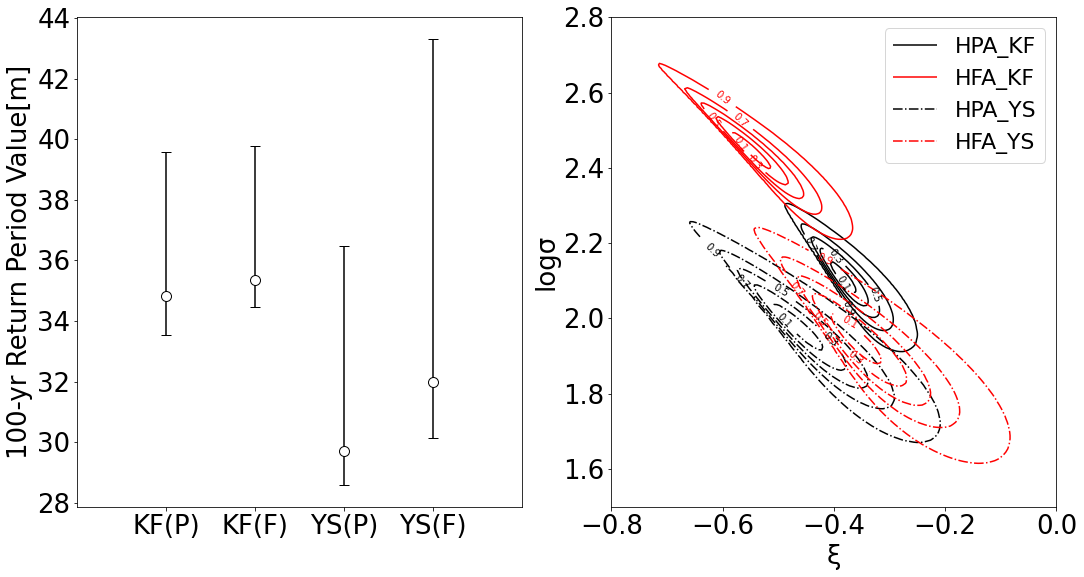

In [25]:
"""
それぞれのモデルのイベントごとの空間最大値を算出する.
それらの上位DATA_CNT個の点に対して, 極値統計解析を行い, 現在と過去で比較する
"""

from csv import reader
import matplotlib.pyplot as plt
import numpy as np
import func
import csv
import math

MODEL = ['KF', 'YS']
DATA_CNT = 50
RV = []
PARAM = []

for model_num in range(len(MODEL)):
    for num in range(2):
        model = MODEL[model_num]
        if num == 0:
            model = 'HPA_' + model
        else:
            model = 'HFA_' + model + '_c0'

        print(model)

        with open('../pot_csv(100)(thr=6)/' + model + '_POT_DATA.csv', 'r') as csv_file:
            csv_reader = reader(csv_file)
            POT = list(csv_reader)
        with open('../pot_csv(100)(thr=6)/' + model + '_POT_INDEX.csv', 'r') as csv_file:
            csv_reader = reader(csv_file)
            POT_INDEX = list(csv_reader)

        DATA = []  # [Hsのindex, Hs]の配列
        for i in range(len(POT)):
            for j in range(len(POT[i])):
                DATA.append([int(POT_INDEX[i][j]), float(POT[i][j])])
        
        # [Hsのindexがsortされる(小さい順)]
        DATA.sort()

        last_index = 0
        max_val = 0

        EVENT_POT = [[]]  # イベントごとのPOTを収納
        for data in DATA:
            if data[1] > 15.0:
                if data[0] > last_index + 24 * 7:
                    EVENT_POT.append([data[0], data[1]])
                    last_index = data[0]
                    max_val = data[1]
                else:
                    if data[1] > max_val:
                        EVENT_POT[-1] = [data[0], data[1]]
                        last_index = data[0]
                        max_val = data[1]
        
        EVENT_POT.pop(0)

        POT_DATA = []  # 空間最大波高
        for pot in EVENT_POT:
            POT_DATA.append(math.floor(pot[1] * 100) / 100)
        # 大きい順にsort
        POT_DATA.sort(reverse=True)
        # 書き出し
        with open(model + '_pot_data.csv', 'w') as file:
            writer = csv.writer(file, lineterminator='\n')
            writer.writerow(POT_DATA)

        print('POTデータの範囲', POT_DATA[-1], '~', POT_DATA[0], 'POTデータ数:', len(POT_DATA))
        
        rv, param = func.lwm_gpd(data=POT_DATA, error=[0.005], thr=POT_DATA[-1], n=219143*79*79, n0=len(POT_DATA), con=0.95)
        RV.append(rv)
        PARAM.append(param)


fig1 = plt.figure(figsize=(16, 8))
ax1 = fig1.add_subplot(1, 2, 1)
ax2 = fig1.add_subplot(1, 2, 2)
# RVの描画
a = ax1.errorbar(
    x=[1, 2, 3, 4],
    y=[RV[0][1], RV[1][1], RV[2][1], RV[3][1]],
    yerr=np.array(
        [
            [RV[0][1] - RV[0][0], RV[1][1] - RV[1][0], RV[2][1] - RV[2][0], RV[3][1] - RV[3][0]],
            [RV[0][2] - RV[0][1], RV[1][2] - RV[1][1], RV[2][2] - RV[2][1], RV[3][2] - RV[3][1]]
        ]
    ),
    capsize=5,
    fmt='o',
    markersize=10,
    ecolor='black',
    markeredgecolor='black',
    color='w'
)
ax1.set_xlim((0, 5))
ax1.set_xticks([1, 2, 3, 4])
ax1.set_xticklabels(['KF(P)', 'KF(F)', 'YS(P)', 'YS(F)'], fontsize=26)
ax1.set_ylabel('100-yr Return Period Value[m]', fontsize=26)
ax1.tick_params(axis='y', labelsize=26)

# パラメータ等高線の描画
for i in range(4):
    p = PARAM[i]
    xi, sgm, sum_prob = p
    log_sgm = [math.log(s) for s in sgm]
    X, Y = np.meshgrid(xi, log_sgm)
    Z = np.array([[sum_prob[i, j] for i in range(200)] for j in range(200)])
    if i == 0:  
        cntr = ax2.contour(X, Y, Z, levels=[0.1, 0.3, 0.5, 0.7, 0.9], colors='black')
        h0,_ = cntr.legend_elements()
        ax2.clabel(cntr)
    if i == 1:
        cntr = ax2.contour(X, Y, Z, levels=[0.1, 0.3, 0.5, 0.7, 0.9], colors='red')
        h1,_ = cntr.legend_elements()
        ax2.clabel(cntr)
    if i == 2:
        cntr = ax2.contour(X, Y, Z, levels=[0.1, 0.3, 0.5, 0.7, 0.9], colors='black', linestyles='dashdot')
        h2,_ = cntr.legend_elements()
        ax2.clabel(cntr)
    if i == 3:
        cntr = ax2.contour(X, Y, Z, levels=[0.1, 0.3, 0.5, 0.7, 0.9], colors='red', linestyles='dashdot')
        h3,_ = cntr.legend_elements()
        ax2.clabel(cntr)
ax2.legend([h0[0], h1[0], h2[0], h3[0]], ['HPA_KF', 'HFA_KF', 'HPA_YS', 'HFA_YS'], fontsize=22)
ax2.set_xlim((-0.8, 0))
ax2.set_ylim((1.5, 2.8))
ax2.set_xlabel("ξ", fontsize=26)
ax2.set_ylabel("logσ", fontsize=26)
ax2.tick_params(axis='x', labelsize=26)
ax2.tick_params(axis='y', labelsize=26)

fig1.subplots_adjust(left=0.1, right=0.95, bottom=0.1, top=0.95) #この1行を入れる
plt.savefig("../img/100y-rv_of_stm.png")
plt.show()